In [1]:
from helpers_merging import *

initial_power = 100* si.uW
initial_waist = 1.1*si.uW
initial_distance = 3*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power*1.04583875,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

x, y, z = trap.x, trap.y, trap.z

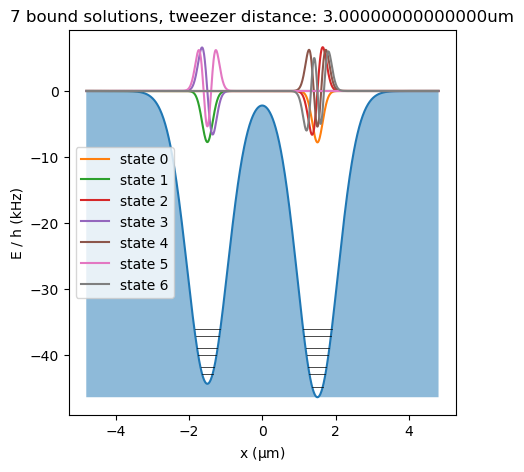

In [2]:
left_cutoff = -0.5*initial_distance-3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*initial_distance+3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])

trap[trap.distance_tweezers] = initial_distance
plot_solutions(trap,7,left_cutoff,right_cutoff,display_plot=-1,state_mult=40,n_pot_steps=1000,plot=True,ret_results=False)

In [3]:
power2_factors = np.linspace(1+1e-5,1.2,75)
deltaEs = np.zeros_like(power2_factors)
occ_numbers = np.zeros((len(power2_factors),2))

for i, pow in enumerate(power2_factors):
    trap[trap.power_tweezer2] = initial_power*pow

    distances = np.linspace(initial_distance,0*si.um,500)
    energies, states, potentials = loop_distances(trap, distances,n_levels=5,n_pot_steps=2000)

    new_energies, new_states, new_potentials, index_top, index, swap_index = swapped_loop_distance(distances, energies, states, potentials)
    energies_left, energies_right, states_left, states_right,deltaE_min, occ_num = find_ass_tweezer(new_energies,new_states)

    deltaEs[i] = deltaE_min
    occ_numbers[i] = occ_num

crossover of states [[2 3]] at 1.52um
crossover of states [[0 1]] at 1.41um
crossover of top state at 1.30um
crossover of top state at 1.30um
crossover of top state at 1.32um
crossover of top state at 1.33um
crossover of states [[1 2]] at 1.32um
crossover of states [[3 4]] at 1.41um
crossover of states [[1 2]] at 1.40um
crossover of states [[1 2]] at 1.53um
crossover of states [[3 4]] at 1.52um
crossover of states [[1 2]] at 1.75um
crossover of states [[3 4]] at 1.70um
crossover of states [[2 3]] at 1.36um
crossover of states [[2 3]] at 1.41um
crossover of states [[2 3]] at 1.47um
crossover of top state at 1.46um
crossover of states [[2 3]] at 1.54um
crossover of top state at 1.52um
crossover of states [[2 3]] at 1.63um
crossover of top state at 1.61um
crossover of states [[2 3]] at 1.75um
crossover of top state at 1.71um
crossover of states [[2 3]] at 1.99um
crossover of top state at 1.88um
crossover of top state at 1.11um
crossover of top state at 1.29um
crossover of top state at 1.1

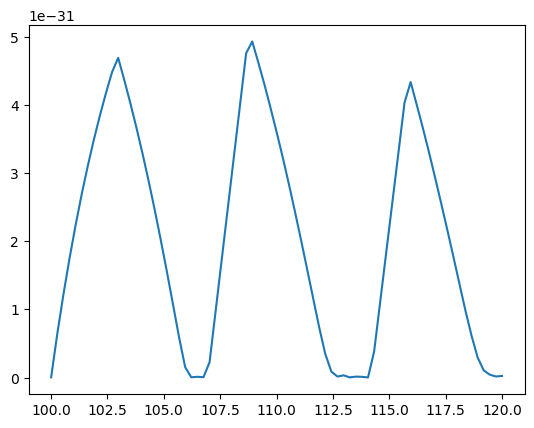

In [10]:
plt.plot(initial_power*power2_factors/si.uW, deltaEs)
#plt.ylim(0,1e-3)

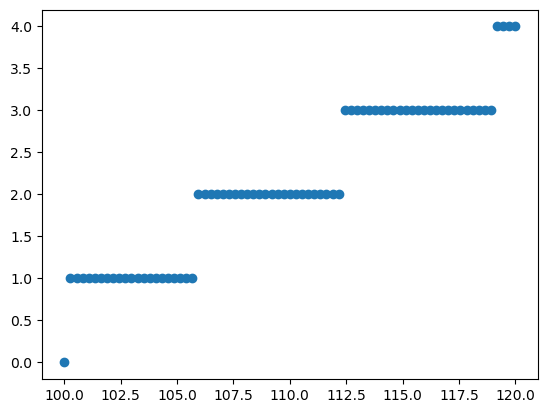

In [5]:
plt.plot(initial_power*power2_factors/si.uW, occ_numbers[:,1],"o")


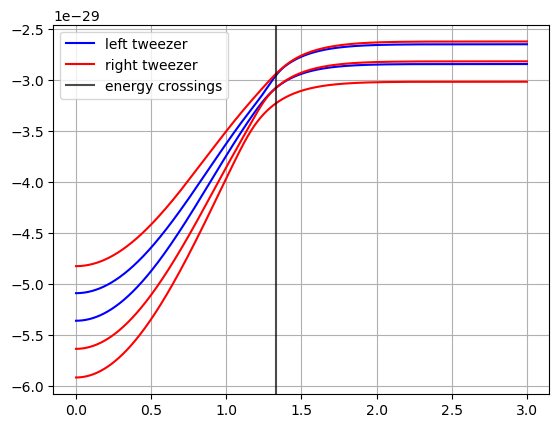

In [11]:
plt.plot(distances/si.um,energies_left,color="blue",label="left tweezer")
plt.plot(distances/si.um,energies_right,color="red",label="right tweezer")

for i, ind in enumerate(index):
    plt.axvline(distances[ind]/si.um,color="k",alpha=0.7,label="energy crossings")

#plt.xlim(1.2,1.4)
#plt.ylim(-1.75e-29,-1.3e-29)
#plt.axhline(-1.55e-29)
#plt.axhline(-1.55e-29+delta_E_min)

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicates
plt.legend(unique_labels.values(), unique_labels.keys())
plt.grid()
plt.show()

----------------

In [10]:
distances = np.linspace(initial_distance,0*si.um,500)
energies, states, potentials = loop_distances(trap, distances,n_levels=5)

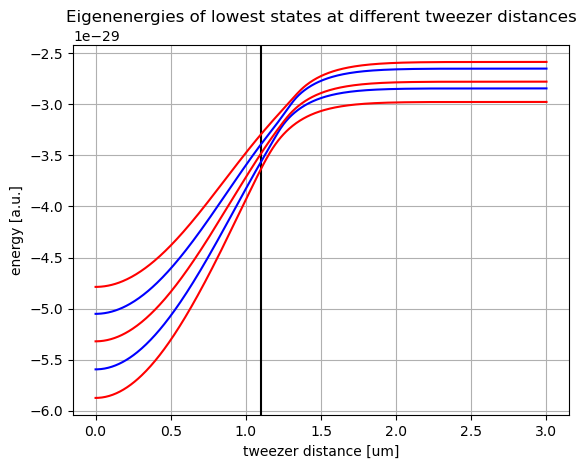

In [11]:
#plot eigenenergies
plt.axvline(float(trap.subs(trap.waist_tweezer1))/si.um, color="black",label="tweezer waist")
for i in range(len(energies[0])):
    #differentiate states that are coming from right and left tweezer
    if np.sum(states[0,i,:int(states.shape[2]/2)]**2) < 0.5:
        plt.plot(distances/si.um,energies[:,i],color="red",label=f"state {i}")
    else:
        plt.plot(distances/si.um,energies[:,i],color="blue",label=f"state {i}")

plt.title("Eigenenergies of lowest states at different tweezer distances")
plt.xlabel("tweezer distance [um]")
plt.ylabel("energy [a.u.]")
#plt.xlim(1.8,2.3)
#plt.ylim(-1.7e-29,-1.2e-29)

plt.grid()
#plt.legend()
plt.show()

In [12]:
new_energies, new_states, new_potentials, index_top, index, swap_index = swapped_loop_distance(distances, energies, states, potentials)

crossover of top state at 1.30um


In [16]:
#seperate energies and states corresponding to the initial tweezer they belonged to
mask_right = np.where(np.sum(new_states[0,:,:int(new_states.shape[2]/2)]**2,axis=1) < 0.5,True, False)
mask_left = np.logical_not(mask_right)

energies_right = new_energies[:,mask_right]
energies_left = new_energies[:,mask_left]

states_right = new_states[:,mask_right,:]
states_left = new_states[:,mask_left,:]

#identify GS of shallower tweezer and calculated minimal energy difference to other states
if mask_left[np.nanargmin(new_energies[0])]:
    energy_GS = energies_right[:,0]
    state_GS = states_right[:,0]
    #smallest energy difference
    delta_E_min = np.nanmin(np.abs(energy_GS[:,np.newaxis] - energies_left))
    #final occupation if two GS are involved
    occ_numbers = np.array([0,np.searchsorted(energies_left[-1],energy_GS[-1])])
else:
    energy_GS = energies_left[:,0]
    state_GS = states_left[:,0]
    #smallest energy difference
    delta_E_min = np.nanmin(np.abs(energy_GS[:,np.newaxis] - energies_right))
    #final occupation if two GS are involved
    occ_numbers = np.array([0,np.searchsorted(energies_right[-1],energy_GS[-1])])

print(delta_E_min)
print(occ_numbers)

2.4799128624867176e-31
[0 1]


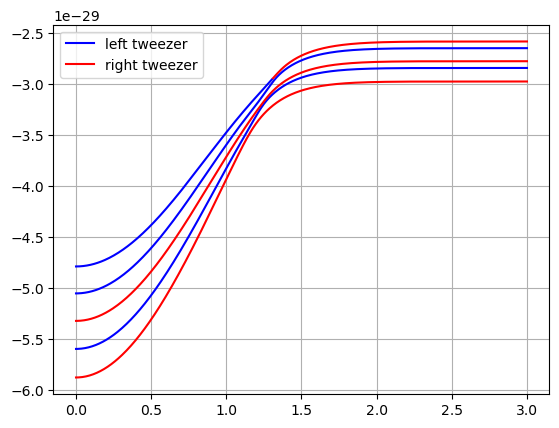

In [14]:
plt.plot(distances/si.um,energies_left,color="blue",label="left tweezer")
plt.plot(distances/si.um,energies_right,color="red",label="right tweezer")

for i, ind in enumerate(index):
    plt.axvline(distances[ind]/si.um,color="k",alpha=0.7,label="energy crossings")

#plt.xlim(1.2,1.4)
#plt.ylim(-1.75e-29,-1.3e-29)
#plt.axhline(-1.55e-29)
#plt.axhline(-1.55e-29+delta_E_min)

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicates
plt.legend(unique_labels.values(), unique_labels.keys())
plt.grid()
plt.show()